Лаба 2 NLP



In [1]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
import string 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", "train.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv", "test.csv")
class_labels = ['World','Sports','Business','Sci/Tech']
df = pd.read_csv('train.csv', encoding='latin-1', names=["Class", "Title", "Message"])
df_test = pd.read_csv('test.csv', encoding='latin-1', names=["Class", "Title", "Message"])

In [6]:
print(df.head(n=10))
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Class    120000 non-null  int64 
 1   Title    120000 non-null  object
 2   Message  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Опишем классы и посмотрим их распределение

Text(0.5, 1.0, 'Распределение классов по датасету')

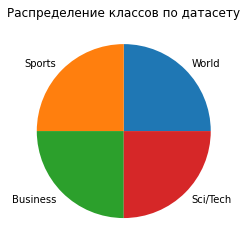

In [17]:
plt.pie(df["Class"].value_counts(), labels=class_labels)
plt.title("Распределение классов по датасету")

Провизуализируем длины сообщений 

Минимальная длина сообщения: 30
Максимальная длина сообщения: 153


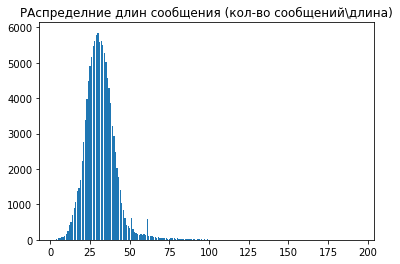

In [42]:
df["Length"] = df["Message"].map(lambda x: len(x.split(' ')))
plt.bar(x = df["Length"].value_counts().keys(), height=df["Length"].value_counts().values)
plt.title("РАспределние длин сообщения (кол-во сообщений\длина)")
print(f"Минимальная длина сообщения: {df['Length'].value_counts().keys()[0]}")
print(f"Максимальная длина сообщения: {df['Length'].value_counts().keys()[-1]}")

Теперь построим таблицу распределения слов по классам и таблицу самых встречаемых и самых редких слов


In [96]:
def words_info(treshold = 9999999999):
  result = []
  for y in range(1, 5):
    t = dict()
    for i in df[df["Class"] == y]["Message"].map(lambda x: x.split(' ')):
      for j in i:
        if j not in t.keys():
          t[j] = 0
        t[j] += 1
    t = dict(sorted(t.items(), key=lambda item: item[1], reverse=True))
    t = { i: t[i] for i in t.keys() if t[i] < treshold}
    result.append(pd.DataFrame.from_dict(t, orient='index', columns=[f"Frequency for class '{class_labels[y-1]}'"]).head(n=30))
  return result
  
for t in words_info(3000):
  print(t)
  print('\n')

            Frequency for class 'World'
its                                2965
have                               2962
AP                                 2768
it                                 2605
were                               2532
(Reuters)                          2478
Iraq                               2457
two                                2437
US                                 2395
their                              2388
be                                 2302
killed                             2267
he                                 2235
Minister                           2192
people                             2148
will                               2095
are                                2074
who                                2044
government                         2032
said.                              1963
over                               1907
Prime                              1768
Iraqi                              1764
officials                          1692


Видим, что больше всего встречаются стоп слова , знаки пунктуации и спецсимволы, а так же отдельновыраженные маркеры для каждого из классов. 
Reuters, AP - новостные агенства, не несут никакой роли. 

Sport - leagye, cup, game (persons, locations, sport words)

World - government, Ministries, U.S. (countries, persons)

Sci\Tech - Microsoft, software, Internet (technology)

Business - Million, billion, prices, company (numbers, businessmaans)

Эти признаки помогут при кластеризации


**Препроцессинг базовый**

Удалим знаки препинания и спец символы из обоих столбцов

In [3]:
for column in ["Title", "Message"]:
  df[column] = [i.lower() for i in  df[column]] #lower case
  df[column] = [re.sub(r'\S*@\S*\s?','',i) for i in  df[column]] 
  df[column] = df[column].replace(r'http\s+|www.\s+','',regex=True).replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) #remove adresses
  for c in ['&lt;', '&gt', 'href=', "#39;", "'s", "--", " - "]:
    df[column] = df[column].map(lambda x: x.replace(c,' '))
  for c in '<.*?>+"()[],!?%\'':
    df[column] = df[column].map(lambda x: x.replace(c,' '))
  for c in r'\/':
    df[column] = df[column].map(lambda x: x.replace(c,' '))
  df[column] = df[column].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [125]:
words_info(10000)

[           Frequency for class 'World'
 for                               8393
 said                              7408
 that                              6633
 an                                5528
 s                                 5209
 as                                5158
 at                                5142
 with                              5129
 by                                4868
 his                               4679
 has                               4407
 was                               4306
 from                              4071
 us                                4001
 reuters                           3967
 is                                3934
 president                         3720
 after                             3480
 its                               2973
 have                              2947
 ap                                2945
 minister                          2910
 two                               2905
 iraq                              2888


Теперь можем начать процесс кластеризации. Отделим классы и соединим заголовки с текстом сообщения: 

In [4]:
data = pd.DataFrame()
data["Class"] = df["Class"]
data["Text"] = df["Title"] + " "+ df["Message"]

In [144]:
data.head(n=5)

,Class,Text
0,3,wall st bears claw back into the black reuters...
1,3,carlyle looks toward commercial aerospace reut...
2,3,oil and economy cloud stocks outlook reuters r...
3,3,iraq halts oil exports from main southern pipe...
4,3,oil prices soar to alltime record posing new m...


Соберем весь текст и протокенизируем. Оставим этот токенизатор для последующих обработок и тестирования, он более полный.

In [51]:
vectorizer = TfidfVectorizer(max_features = 1000)
X = vectorizer.fit_transform(data['Text'])

мы подготовили данные к обучению, теперь вектора подаем модели kmeans, у которой мы найдем число K оптимальное.

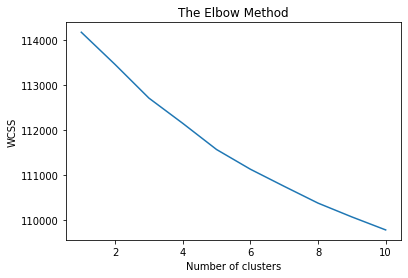

In [252]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

Видим на графике зависимости сумм расстояний между кластерами и количества классов небольшой перелом на k = 4, но явного вывод мы сделать не можем. На исходное распредеелние классов результат работы модели пока не похож, распределение классов отличается от исходного: 

In [52]:
kmeans = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
result = kmeans.fit_predict(X)
{i : list(result).count(i) for i in range(4)}

{0: 8132, 1: 48197, 2: 55843, 3: 7828}

Возьмем рандомную выборку из 10 текстов и посмотрим, как распределяет по разным классам эти тектс ы модель:

In [53]:
for i in range(4990, 5000):
  print( f"class {result[i]} text {data.iloc[i]['Text']}")

class 2 text un chad could see more darfur refugees geneva aug  20  2004  tens of thousands more refugees might flee sudan  s darfur region into neighboring chad because of persistent attacks and rapes by arab militias  the united nations said friday  
class 3 text us warplanes strike falluja report fallujah  iraq  ap   us forces launched two airstrikes today on the troubled iraqi city of falluja  hospital officials and witnesses said  
class 2 text israeli court orders reply for hague jerusalem the israeli supreme court ordered the government to produce a statement in the next 30 days that assesses the ramifications of a nonbinding ruling by the international court of justice in the hague that declared the israeli security barrier    
class 2 text cleric  s aides kidnapped journalist will be freed baghdad  iraq   some of muqtada alsadr  s aides in iraq say kidnappers have promised to release a western journalist  perhaps as early as friday  
class 2 text women lay claim to   miracle c

График зависимости предсказанный label - реальный label

In [78]:
slabels_results = {1:{1:0, 2:0, 3:0, 4:0}, 2:{1:0, 2:0, 3:0, 4:0}, 3:{1:0, 2:0, 3:0, 4:0}, 4:{1:0, 2:0, 3:0, 4:0}}
dlabels = {0:1, 1:2, 2:3, 3:4}
for textid in range(X.shape[0]):
  predicted_label = dlabels[result[textid]]
  true_label = df.iloc[textid]["Class"]
  slabels_results[true_label][predicted_label] += 1

print(f"Распределение: реальный класс \ на какие реальные классы модель выбрала этот класс - {slabels_results}")
def get_fail_prob(cl):
  max_prob = max(cl.values())
  total = sum(cl.values()) 
  return max_prob/total
s = {i : f"{int(get_fail_prob(slabels_results[i])*100)}%" for i in range(1, 5)}
print(f"Уверенность в определении класса для каждого из типов текста: {s}")

Распределение: реальный класс \ на какие реальные классы модель выбрала этот класс - {1: {1: 420, 2: 6418, 3: 20395, 4: 2767}, 2: {1: 14, 2: 3259, 3: 23619, 4: 3108}, 3: {1: 7444, 2: 16540, 3: 5789, 4: 227}, 4: {1: 254, 2: 21980, 3: 6040, 4: 1726}}
Уверенность в определении класса для каждого из типов текста: {1: '67%', 2: '78%', 3: '55%', 4: '73%'}


Как мы видим, модель слабо раскидывает тексты по классам взависимости от темы.

**Усложненный препроцессинг**

Удалим стоп слова из текста

In [39]:
stop = stopwords.words('english')
df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['Message'] = df['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.tail(n=5)

,Class,Title,Message,Text,TextProcessed,FinalText
119995,1,pakistan musharraf says quit army chief,karachi reuters pakistani president pervez mus...,pakistan musharraf says quit army chief karach...,karachi reuters pakistani president pervez mus...,pakistan musharraf says quit army chief karach...
119996,2,renteria signing topshelf deal,red sox general manager theo epstein acknowled...,renteria signing topshelf deal red sox general...,red sox general manager theo epstein acknowled...,renteria signing topshelf deal red sox general...
119997,2,saban going dolphins yet,miami dolphins put courtship lsu coach nick sa...,saban going dolphins yet miami dolphins put co...,miami dolphins put courtship lsu coach nick sa...,saban going dolphins yet miami dolphins put co...
119998,2,today nfl games,pittsburgh ny giants time 130 p line steelers ...,today nfl games pittsburgh ny giants time 130 ...,pittsburgh ny giants time 130 p line steelers ...,today nfl games pittsburgh ny giants time 130 ...
119999,2,nets get carter raptors,indianapolis allstar vince carter traded toron...,nets get carter raptors indianapolis allstar v...,indianapolis allstar vince carter traded toron...,nets get carter raptors indianapolis allstar v...


Далее используем pos-tagging, где мы размечаем отедльно позиции, компании, личностей и оставляем их, не приводя и не удаляя. После этого будем убирать самые встречающиеся во всем тексте (например новостные агенства) и убираем редкие.

Далее из сообщения мы убираем слова из заголовка, соединяем сообщение и получившуюся информацию отдаем на обучение. 

In [40]:
df["Text"] = df["Title"] + " "+ df["Message"]
t = dict()
for i in df["Text"].map(lambda x: x.split(' ')):
  for j in i:
    if j not in t.keys():
      t[j] = 0
    t[j] += 1
probabilities = dict(sorted(t.items(), key=lambda item: item[1], reverse=True))
max_probability = t[list(t)[0]]


In [295]:
df.head(n=5)

,Class,Title,Message,Text
0,3,wall st bears claw back into black,wall street dwindling band are seeing green again,wall st bears claw back into the black reute...
1,3,carlyle looks toward commercial aerospace,private investment firm carlyle group which re...,carlyle looks toward commercial aerospace reu...
2,3,oil economy cloud stocks outlook,soaring crude prices plus worries about econom...,oil and economy cloud stocks outlook reuters...
3,3,iraq halts oil exports main southern pipeline,authorities have halted oil export flows main ...,iraq halts oil exports from main southern pipe...
4,3,oil prices soar alltime record posing menace u...,afp world oil prices toppling records strainin...,oil prices soar to alltime record posing new ...


In [41]:
import spacy

lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
sp = spacy.load('en_core_web_sm')

def get_nnp(st):
  sen = sp(st)
  return [st[i] for i in range(len(sen)) if sen[i].pos_=="NNP"]

def process_prob(x):
  nnp_list = get_nnp(x) #its tooo long to process the whole sent.
  res = [word for word in x.split() if word in probabilities and not (probabilities[word]<10 or probabilities[word]>10000) and not (word in nnp_list) ]
  return ' '.join(res)

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    sen = sp(sentence)
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [42]:
df["TextProcessed"] = df["Message"]
for j in df.index:
  if (j%1000 == 0):
    print(j)
  w = df.iloc[j]["Message"].split(' ')
  title = df.iloc[j]["Title"].split(' ')
  res = ' '.join([w[i] for i in range(len(w)) if not w[i] in title])
  res = lemmatize_sentence(res)
  res = process_prob(res)
  df.iloc[j]["TextProcessed"] = res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Делаем финальную обработку и подаем на кластеризацию.

In [43]:
df["FinalText"] = df["Title"] + " " + df["TextProcessed"]

**Кластеризация**

In [44]:
x = df["FinalText"]
vectorizer = TfidfVectorizer(max_features = 1000)
X = vectorizer.fit_transform(x)

In [48]:
kmeans = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
predicted = kmeans.fit_predict(X)
{i : list(predicted).count(i) for i in range(0,4)}

{0: 7850, 1: 5701, 2: 72949, 3: 33500}

In [47]:
for i in range(9330, 9340):
  print( f"class {predicted[i]} text {df.iloc[i]['FinalText']}")

class 3 text software seeks online bargains consumers united states already spending record amounts money online one ecommerce company novel way help net shoppers hunt bargains holiday season
class 2 text controversy mishandled around athens olympic repo men come looking gold medal seemed paul hamm would old twin spin used work well back home wisconsin quotsorry brother morgan quot paul would say quotpaul parthenon maybe plaka
class 2 text dominant us women squad true dream team athens five games us women outscoring opponents 29 points game dominant point ennui crush opponents glass hand twice many assists per game generally way every game lead olympics nine statistical categories
class 2 text barents sea faces major threats pristine arctic waters barents sea overfished face serious pollution problems un says
class 2 text going deep memories toronto last night doug mientkiewicz call red sox emergency catcher case calamity befell doug mirabelli raising uncomfortable specter onetime mino

Распределение по классам при параметре k = 4 заметно отличается, А теперь проанализируем получившуюся модель, используя существующие метки у каждого из текстов. Опять посмотрим, на какие типы текстов модель давала определенные классы:

In [79]:
labels_results = {1:{1:0, 2:0, 3:0, 4:0}, 2:{1:0, 2:0, 3:0, 4:0}, 3:{1:0, 2:0, 3:0, 4:0}, 4:{1:0, 2:0, 3:0, 4:0}}
dlabels = {0:1, 1:2, 2:3, 3:4}
for textid in range(X.shape[0]):
  predicted_label = dlabels[predicted[textid]]
  true_label = df.iloc[textid]["Class"]
  labels_results[true_label][predicted_label] += 1

print(f"Распределение: реальный класс \ на какие реальные классы модель выбрала этот класс: \n {labels_results}")

Распределение: реальный класс \ на какие реальные классы модель выбрала этот класс: 
 {1: {1: 2770, 2: 382, 3: 26175, 4: 673}, 2: {1: 3115, 2: 12, 3: 26385, 4: 488}, 3: {1: 225, 2: 5216, 3: 10951, 4: 13608}, 4: {1: 1740, 2: 91, 3: 9438, 4: 18731}}


И посчитаем "процент неопределенности" для каждого из класса для простой предобработки и продвинутой

In [80]:
def get_fail_prob(cl):
  max_prob = max(cl.values())
  total = sum(cl.values()) 
  return max_prob/total
d = {i : f"{int(get_fail_prob(labels_results[i])*100)}%" for i in range(1, 5)}
print(f"|Продвинутый препроцессинг|Уверенность в определении класса для каждого из типов текста: {d}")
print(f"|Простой препроцессинг|    Уверенность в определении класса для каждого из типов текста: {s}")

|Продвинутый препроцессинг|Уверенность в определении класса для каждого из типов текста: {1: '87%', 2: '87%', 3: '45%', 4: '62%'}
|Простой препроцессинг|    Уверенность в определении класса для каждого из типов текста: {1: '67%', 2: '78%', 3: '55%', 4: '73%'}


Вывод: После препроцессинга по стоп словам, уменьшение числа используемых слов в зависимости от распределения (с сохранением слов - фактов (NNP)), лемматизации и соединения заголовка с опсианием получаем небольшое изменение в качетсве кластеризации: для двух классов на 20 и 9 % и уменьшили качетсов для двух классов на 10 и 9 процентов. 